### From deepcell/utils/train_utils.py

In [1]:
from __future__ import absolute_import
from __future__ import print_function
from __future__ import division

import numpy as np
from tensorflow.python.keras import activations

def axis_softmax(x, axis=1):
    
    return activations.softmax(x, axis=axis)

def rate_scheduler(lr=.001, decay=0.95):
    def output_fn(epoch):
        epoch = np.int(epoch)
        new_lr = lr * (decay ** epoch)
        return new_lr
    return output_fn

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### From deepcell/image_generators.py

In [2]:
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator, Iterator
from tensorflow.python.keras import backend as K
from skimage.measure import regionprops
from skimage.transform import resize

class SiameseDataGenerator(ImageDataGenerator):
    def flow(self, train_dict, crop_dim=14, min_track_length=5,
             batch_size=32, shuffle=True, seed=None, data_format=None,
             save_to_dir=None, save_prefix='', save_format='png'):
        return SiameseIterator(train_dict, self, crop_dim=crop_dim,
                               min_track_length=min_track_length, batch_size=batch_size,
                               shuffle=shuffle, seed=seed, data_format=data_format,
                               save_to_dir=save_to_dir, save_prefix=save_prefix,
                               save_format=save_format)

class SiameseIterator(Iterator):
    def __init__(self, train_dict, image_data_generator,
                 crop_dim=14, min_track_length=5, batch_size=32, shuffle=False,
                 seed=None, data_format=None, save_to_dir=None, save_prefix='',
                 save_format='png'):
        # Identify the channel axis so the code works regardless of what dimension
        # we are using for channels - the data in the train_dict should be channels last
        if data_format is None:
            data_format = K.image_data_format()

        if data_format == 'channels_first':
            self.channel_axis = 1
            self.row_axis = 3
            self.col_axis = 4
            self.time_axis = 2
        elif data_format == 'channels_last':
            self.channel_axis = 4
            self.row_axis = 2
            self.col_axis = 3
            self.time_axis = 1
        self.x = np.asarray(train_dict['X'], dtype=K.floatx())
        self.y = np.int32(train_dict['y'])
        self.crop_dim = crop_dim
        self.min_track_length = min_track_length
        self.image_data_generator = image_data_generator
        self.data_format = data_format
        self.save_to_dir = save_to_dir
        self.save_prefix = save_prefix
        self.save_format = save_format

        self.track_ids = self._get_track_ids()

        super(SiameseIterator, self).__init__(len(self.track_ids), batch_size, shuffle, seed)

    def _get_track_ids(self):
        """
        This function builds the track id's. It returns a dictionary that
        contains the batch number and label number of each each track.
        Creates unique cell IDs, as cell labels are NOT unique across batches.
        """
        track_counter = 0
        track_ids = {}
        for batch in range(self.y.shape[0]):
            y_batch = self.y[batch]
            num_cells = np.amax(y_batch)
            for cell in range(1, num_cells + 1):
                # count number of pixels cell occupies in each frame
                y_true = np.sum(y_batch == cell, axis=(self.row_axis - 1, self.col_axis - 1))
                # get indices of frames where cell is present
                y_index = np.where(y_true > 0)[0]
                if y_index.size > 0: # if cell is present at all
                    start_frame = np.amin(y_index)
                    stop_frame = np.amax(y_index)
                    track_ids[track_counter] = {
                        'batch': batch,
                        'label': cell,
                        'frames': y_index
                    }
                    track_counter += 1
        return track_ids

    def _get_batches_of_transformed_samples(self, index_array):
        # initialize batch_x_1, batch_x_2, and batch_y
        if self.data_format == 'channels_first':
            img_shape = (len(index_array), self.x.shape[self.channel_axis], self.crop_dim, self.crop_dim)
        else:
            img_shape = (len(index_array), self.crop_dim, self.crop_dim, self.x.shape[self.channel_axis])
        
        data_shape = (len(index_array), 2,)
        batch_x_1 = np.zeros(img_shape, dtype=K.floatx())
        batch_x_2 = np.zeros(img_shape, dtype=K.floatx())
        centroid_1 = np.zeros(data_shape, dtype=K.floatx())
        centroid_2 = np.zeros(data_shape, dtype=K.floatx())
        batch_y = np.zeros((len(index_array), 2), dtype=np.int32)

        for i, j in enumerate(index_array):
            # Identify which tracks are going to be selected
            track_id = self.track_ids[j]
            batch = track_id['batch']
            label_1 = track_id['label']
            tracked_frames = track_id['frames']
            frame_1 = np.random.choice(tracked_frames) # Select a frame from the track

            X = self.x[batch]
            y = self.y[batch]

            # Choose comparison cell
            # Determine what class the track will be - different (0), same (1)
            is_same_cell = np.random.random_integers(0, 1)


            all_labels = np.delete(np.unique(y), 0) # all labels in y but 0 (background)
            acceptable_labels = np.delete(all_labels, np.where(all_labels == label_1))
            
            if len(acceptable_labels) == 0:
                is_same_cell = 1
            
            # Select another frame from the same track
            if is_same_cell:
                label_2 = label_1
                frame_2 = np.random.choice(track_id['frames'])
                
            # Select another frame from a different track
            if not is_same_cell:
                # all_labels = np.arange(1, np.amax(y) + 1)
                #all_labels = np.delete(np.unique(y), 0) # all labels in y but 0 (background)
                #acceptable_labels = np.delete(all_labels, np.where(all_labels == label_1))
                #print("acceptable_labels:", acceptable_labels)
                #print("al_length: ", len(acceptable_labels))
                is_valid_label = False

                while not is_valid_label:
                    # get a random cell label from our acceptable list
                    label_2 = np.random.choice(acceptable_labels)

                    # count number of pixels cell occupies in each frame
                    y_true = np.sum(y == label_2, axis=(
                        self.row_axis - 1, self.col_axis - 1, self.channel_axis - 1))

                    y_index = np.where(y_true > 0)[0] # get frames where cell is present
                    is_valid_label = y_index.any() # label_2 is in a frame
                    if not is_valid_label:
                        # remove invalid label from list of acceptable labels
                        acceptable_labels = np.delete(
                            acceptable_labels, np.where(acceptable_labels == label_2))

                frame_2 = np.random.choice(y_index) # get random frame with label_2

            # Get appearances
            frames = [frame_1, frame_2]
            labels = [label_1, label_2]

            appearances = self._get_appearances(X, y, frames, labels)

            centroid_1[i] = np.array(appearances[1][0])
            centroid_2[i] = np.array(appearances[1][1])
            
            #print("centroids: ", centroids, "     shape: ", centroids.shape)
            #print("type: ", type(centroids), "    elem type: ", centroids[0].shape)
            appearances = appearances[0]
            #print("appearances type: ", type(appearances), "     length: ", len(appearances))
            

            if self.data_format == 'channels_first':
                appearances = [appearances[:, 0], appearances[:, 1]]
            else:
                appearances = [appearances[0], appearances[1]]

            # Apply random transformations
            for k, appearance in enumerate(appearances):
                appearance = self.image_data_generator.random_transform(appearance)
                appearance = self.image_data_generator.standardize(appearance)
                appearances[k] = appearance

            batch_x_1[i] = appearances[0]
            batch_x_2[i] = appearances[1]
            #print("input1 model: ", type(batch_x_1), "    shape: ", batch_x_1.shape)
            #print("centroid_1: ", type(centroid_1), "     shape: ", centroid_1.shape)
            
            batch_y[i, is_same_cell] = 1

        return ([batch_x_1, batch_x_2, centroid_1, centroid_2], batch_y)

    def _get_appearances(self, X, y, frames, labels):
        channel_axis = self.channel_axis - 1
        if self.data_format == 'channels_first':
            appearance_shape = (X.shape[channel_axis], len(frames), self.crop_dim, self.crop_dim)
        else:
            appearance_shape = (len(frames), self.crop_dim, self.crop_dim, X.shape[channel_axis])
        appearances = np.zeros(appearance_shape, dtype=K.floatx())
        centroids = []
        for counter, (frame, cell_label) in enumerate(zip(frames, labels)):
            # Get the bounding box
            y_frame = y[frame] if self.data_format == 'channels_last' else y[:, frame]
            props = regionprops(np.int32(y_frame == cell_label))
            minr, minc, maxr, maxc = props[0].bbox
            centroids.append(props[0].centroid)
            # Extract images from bounding boxes
            if self.data_format == 'channels_first':
                appearance = X[:, frame, minr:maxr, minc:maxc]
                resize_shape = (X.shape[channel_axis], self.crop_dim, self.crop_dim)
            else:
                appearance = X[frame, minr:maxr, minc:maxc, :]
                resize_shape = (self.crop_dim, self.crop_dim, X.shape[channel_axis])

            # Resize images from bounding box
            max_value = np.amax([np.amax(appearance), np.absolute(np.amin(appearance))])
            appearance /= max_value
            appearance = resize(appearance, resize_shape)
            appearance *= max_value
            if self.data_format == 'channels_first':
                appearances[:, counter] = appearance
            else:
                appearances[counter] = appearance

        return [appearances, centroids]

    def next(self):
        """For python 2.x.
        # Returns the next batch.
        """
        # Keeps under lock only the mechanism which advances
        # the indexing of each batch.
        with self.lock:
            index_array = next(self.index_generator)
        # The transformation of images is not under thread lock
        # so it can be done in parallel
        return self._get_batches_of_transformed_samples(index_array)

In [31]:
import numpy as np
from deepcell.utils import get_data

data = np.load('/data/npz_data/cells/unspecified_nuclear_data/nuclear_movie/nuclear_movie_same.npz')
train_dict, (X_test, y_test) = get_data('/data/npz_data/cells/unspecified_nuclear_data/nuclear_movie/nuclear_movie_same.npz',
                                        mode='siamese')
image_data_generator = SiameseDataGenerator(
        rotation_range=0,  # randomly rotate images by 0 to rotation_range degrees
        shear_range=0, # randomly shear images in the range (radians , -shear_range to shear_range)
        horizontal_flip=0,  # randomly flip images
        vertical_flip=0) 

test_iterator = SiameseIterator(train_dict, image_data_generator, crop_dim=32)
#test_iterator._get_track_ids()


In [32]:

(lst, y) = test_iterator.next()

# = data[0]

#centroids = data[1]

#print(lst[0].shape)


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:104: DeprecationWarning: This function is deprecated. Please call randint(0, 1 + 1) instead
/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


In [33]:
print(y)

[[1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [0 1]
 [0 1]
 [0 1]
 [1 0]
 [0 1]
 [0 1]
 [1 0]
 [0 1]
 [1 0]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [1 0]
 [0 1]
 [1 0]
 [0 1]
 [0 1]
 [1 0]
 [1 0]
 [1 0]
 [0 1]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [0 1]]


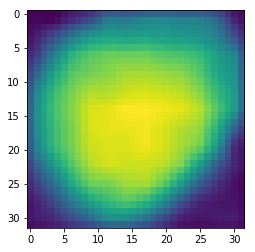

In [34]:
import matplotlib.pyplot as plt
from skimage.io import imshow
plt.imshow(lst[0][1,:,:,0])


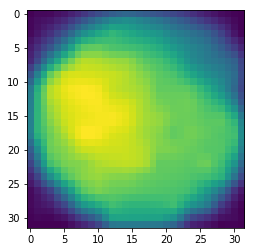

In [35]:
plt.imshow(lst[1][1,:,:,0])

In [36]:
print(lst[2])


[[ 35.07     434.5     ]
 [ 29.32353  201.47058 ]
 [ 30.326733  73.84158 ]
 [ 29.336538 143.97116 ]
 [ 11.93007  298.3147  ]
 [ 32.0099   184.16832 ]
 [ 21.404581 324.8015  ]
 [ 29.362318 276.5797  ]
 [ 45.719696 377.9394  ]
 [ 78.65487  150.00885 ]
 [ 16.872341 392.7447  ]
 [ 21.92381    8.32381 ]
 [ 68.358696  93.815216]
 [ 47.642857  39.86607 ]
 [ 46.873016 181.56349 ]
 [ 53.502514 322.27637 ]
 [ 35.689655 471.12643 ]
 [ 54.70297   83.14851 ]
 [ 55.453335 434.54666 ]
 [ 64.4321   289.7284  ]
 [ 64.68276  248.71724 ]
 [ 82.43137  346.35294 ]
 [ 44.88889   63.287037]
 [ 71.17757  408.49533 ]
 [ 93.662254 177.33775 ]
 [ 93.86364  283.12878 ]
 [ 95.871796 200.38461 ]
 [ 70.15      41.27    ]
 [ 89.21667   21.083334]
 [105.51376  159.85321 ]
 [ 86.297295 263.2072  ]
 [ 84.611115 423.99445 ]]


In [37]:
print(len(lst))

4


### From deepcell/training.py

In [3]:
from scipy.spatial import distance
def siamese_model(input_shape=None, batch_shape=None, reg=1e-5, init='he_normal', permute=False, softmax=True, norm_method='std', filter_size=61):

    if K.image_data_format() == 'channels_first':
        channel_axis = 1
    else:
        channel_axis = -1

    input_1 = Input(shape=input_shape)
    input_2 = Input(shape=input_shape)
    input_3 = Input(shape=(2, ))
    input_4 = Input(shape=(2, ))
    
    # Sequential interface for siamese portion of model
    feature_extractor = Sequential()
    feature_extractor.add(Conv2D(64, (3, 3), kernel_initializer=init, padding='same', kernel_regularizer=l2(reg), input_shape=input_shape))
    feature_extractor.add(BatchNormalization(axis=channel_axis))
    feature_extractor.add(Activation('relu'))
    feature_extractor.add(Conv2D(64, (3, 3), kernel_initializer=init, padding='same', kernel_regularizer=l2(reg)))
    feature_extractor.add(BatchNormalization(axis=channel_axis))
    feature_extractor.add(Activation('relu'))
    feature_extractor.add(MaxPool2D(pool_size=(2, 2)))
    feature_extractor.add(Conv2D(64, (3, 3), kernel_initializer=init, padding='same', kernel_regularizer=l2(reg)))
    feature_extractor.add(BatchNormalization(axis=channel_axis))
    feature_extractor.add(Activation('relu'))
    feature_extractor.add(Conv2D(64, (3, 3), kernel_initializer=init, padding='same', kernel_regularizer=l2(reg)))
    feature_extractor.add(BatchNormalization(axis=channel_axis))
    feature_extractor.add(Activation('relu'))
    feature_extractor.add(MaxPool2D(pool_size=(2, 2)))

    # Create two instances of feature_extractor
    output_1 = feature_extractor(input_1)
    #merged_output1 = concatenate([output_1, input_3], axis=channel_axis)
    ##gmp_1 = GlobalMaxPooling2D()(output1)
    ##gmp_2 = GlobalMaxPooling2D()(input_3)
    ##merged_output1 = concatenate([gmp_1, gmp_2])
    
    output_2 = feature_extractor(input_2)
    #merged_output2 = concatenate([output_2, input_4], axis=channel_axis)

    flat1 = Flatten()(output_1)
    flat2 = Flatten()(output_2)
    #flat3 = Flatten()(input_3)
    #flat4 = Flatten()(input_4)
    merge_1 = concatenate([flat1, input_3])
    merge_2 = concatenate([flat2, input_4])
    # Concatenate outputs from both feature_extractor instances
    """
    merged_outputs = Concatenate(axis=channel_axis)([output_1, output_2])
    flat1 = Flatten()(merged_outputs)
    distance = tf.sqrt(tf.reduce_sum(tf.square(tf.subtract(input_3, input_4))))
    print(distance, "     type:", type(distance))
    merge_dist = concatenate([flat1, distance])
    """
    merged_outputs = Concatenate(axis=channel_axis)([merge_1, merge_2])
    # Implement dense net (or call preexisting one?) with the two outputs as inputs
    #dense1 = Dense(128)(merge_dist)
    dense1 = Dense(128)(merged_outputs)
    bn1 = BatchNormalization(axis=channel_axis)(dense1)
    relu1 = Activation('relu')(bn1)
    dense2 = Dense(128)(relu1)
    bn2 = BatchNormalization(axis=channel_axis)(dense2)
    relu2 = Activation('relu')(bn2)
    dense3 = Dense( 2, activation='softmax')(relu2)

    # Instantiate model
    final_layer = dense3
    model = Model(inputs=[input_1, input_2, input_3, input_4], outputs=final_layer)
    print(model.summary())

    return model

In [8]:
from deepcell.losses import categorical_crossentropy, weighted_categorical_crossentropy
from tensorflow.python.keras.callbacks import ModelCheckpoint, LearningRateScheduler

def train_model_siamese(model=None, dataset=None, optimizer=None,
                        expt='', it=0, batch_size=1, n_epoch=100,
                        direc_save='/data/models', direc_data='/data/npz_data',
                        lr_sched=rate_scheduler(lr=0.01, decay=0.95),
                        rotation_range=0, flip=True, shear=0, class_weight=None):
    CHANNELS_FIRST = False
    training_data_file_name = os.path.join(direc_data, dataset + '.npz')
    todays_date = datetime.datetime.now().strftime('%Y-%m-%d')

    file_name_save = os.path.join(direc_save, '{}_{}_{}_{}.h5'.format(todays_date, dataset, expt, it))
    file_name_save_loss = os.path.join(direc_save, '{}_{}_{}_{}.npz'.format(todays_date, dataset, expt, it))

    train_dict, (X_test, y_test) = get_data(training_data_file_name, mode='siamese')

    class_weights = train_dict['class_weights']
    # the data, shuffled and split between train and test sets
    print('X_train shape:', train_dict['X'].shape)
    print('y_train shape:', train_dict['y'].shape)
    print('X_test shape:', X_test.shape)
    print('y_test shape:', y_test.shape)
    print('Output Shape:', model.layers[-1].output_shape)

    n_classes = model.layers[-1].output_shape[1 if CHANNELS_FIRST else -1]

    #model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    def loss_function(y_true, y_pred):
        return weighted_categorical_crossentropy(y_true, y_pred,
                                                 n_classes=n_classes,
                                                 from_logits=False)
    
    model.compile(loss=loss_function, optimizer=optimizer, metrics=['accuracy'])

    print('Using real-time data augmentation.')

    # this will do preprocessing and realtime data augmentation
    datagen = SiameseDataGenerator(
        rotation_range=rotation_range,  # randomly rotate images by 0 to rotation_range degrees
        shear_range=shear, # randomly shear images in the range (radians , -shear_range to shear_range)
        horizontal_flip=flip,  # randomly flip images
        vertical_flip=flip)  # randomly flip images

    datagen_val = SiameseDataGenerator(
        rotation_range=0,  # randomly rotate images by 0 to rotation_range degrees
        shear_range=0, # randomly shear images in the range (radians , -shear_range to shear_range)
        horizontal_flip=0,  # randomly flip images
        vertical_flip=0)  # randomly flip images

    validation_dict = {'X': X_test, 'y': y_test}

    def count_pairs(y):
        """
        Compute number of training samples needed to (stastically speaking)
        observe all cell pairs.
        Assume that the number of images is encoded in the second dimension.
        Assume that y values are a cell-uniquely-labeled mask.
        Assume that a cell is paired with one of its other frames 50% of the time
        and a frame from another cell 50% of the time.
        """
        # TODO: channels_first axes
        total_pairs = 0
        for image_set in range(y.shape[0]):
            set_cells = 0
            cells_per_image = []
            for image in range(y.shape[1]):
                image_cells = int(y[image_set, image, :, :, :].max())
                set_cells = set_cells + image_cells
                cells_per_image.append(image_cells)

            # Since there are many more possible non-self pairings than there are self pairings,
            # we want to estimate the number of possible non-self pairings and then multiply
            # that number by two, since the odds of getting a non-self pairing are 50%, to
            # find out how many pairs we would need to sample to (statistically speaking)
            # observe all possible cell-frame pairs.
            # We're going to assume that the average cell is present in every frame. This will
            # lead to an underestimate of the number of possible non-self pairings, but it's
            # unclear how significant the underestimate is.
            average_cells_per_frame = int(sum(cells_per_image) / len(cells_per_image))
            non_self_cellframes = (average_cells_per_frame - 1) * len(cells_per_image)
            non_self_pairings = non_self_cellframes * max(cells_per_image)
            cell_pairings = non_self_pairings * 2
            total_pairs = total_pairs + cell_pairings
        return total_pairs

    # This shouldn't remain long term.
    #magic_number = 2048  # A power of 2 chosen just to reduce training time.
    total_train_pairs = count_pairs(train_dict['y'])
    print("total_train_pairs:", total_train_pairs)
    #total_train_pairs = int(total_train_pairs // magic_number)
    #print("total_train_pairs:", total_train_pairs)

    total_test_pairs = count_pairs(y_test)
    #print("total_test_pairs:", total_test_pairs)
    #total_test_pairs = int(total_test_pairs // magic_number)
    print("total_test_pairs:", total_test_pairs)
    print("batch size: ", batch_size)
    print("validation_steps: ", total_test_pairs // batch_size)
    test_1, test_2 = datagen.flow(train_dict, batch_size=batch_size, crop_dim=32).next()


    
    # fit the model on the batches generated by datagen.flow()
    loss_history = model.fit_generator(
        datagen.flow(train_dict, batch_size=batch_size, crop_dim=32),
        steps_per_epoch=total_train_pairs // batch_size,
        epochs=n_epoch,
        validation_data=datagen_val.flow(validation_dict, batch_size=batch_size, crop_dim=32),
        validation_steps=total_test_pairs // batch_size,
        callbacks=[
            ModelCheckpoint(file_name_save, monitor='val_loss', verbose=1, save_best_only=True, mode='auto'),
            LearningRateScheduler(lr_sched)
        ])

    model.save_weights(file_name_save)
    np.savez(file_name_save_loss, loss_history=loss_history.history)

    return model


### From deepcell/scripts/testing_scripts/nuclear_movie_generator_test.py

In [ ]:
from tensorflow.python.keras.optimizers import SGD
import tensorflow as tf
import os
import datetime
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.activations import softmax
from tensorflow.python.keras.callbacks import ModelCheckpoint
from tensorflow.python.keras.models import Sequential, Model
from tensorflow.python.keras.layers import Add, Permute, Input, Concatenate, concatenate
from tensorflow.python.keras.layers import Conv2D, Conv3D, MaxPool2D, AvgPool2D
from tensorflow.python.keras.layers import Flatten, Dense, Dropout
from tensorflow.python.keras.layers import Activation, Softmax
from tensorflow.python.keras.layers import BatchNormalization
from tensorflow.python.keras.regularizers import l2

from deepcell.utils import get_data



#direc_data = '/data/npz_data/cells/HeLa/S3/movie/'
#dataset = 'nuclear_movie_hela2_raw_same'
direc_data = '/data/npz_data/cells/HeLa/S3/set2/movie1/'
dataset = 'nuclear_movie_HeLa2_raw_same'

training_data = np.load('{}{}.npz'.format(direc_data, dataset))

optimizer = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
lr_sched = rate_scheduler(lr=0.01, decay=0.99)
in_shape = (32, 32, 1)
model = siamese_model(input_shape=in_shape)
for layer in model.layers:
    print(layer.name)

train_model_siamese(model=model,
                    dataset='nuclear_movie_HeLa2_raw_same',
                    optimizer=optimizer,
                    expt='',
                    it=0,
                    batch_size=128,
                    n_epoch=10,
                    direc_save='/data/models/cells/HeLa/S3',
                    direc_data='/data/npz_data/cells/HeLa/S3/set2/movie1/',
                    lr_sched=lr_sched,
                    rotation_range=0,
                    flip=True,
                    shear=0,
                    class_weight=None)


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           (None, 32, 32, 1)    0                                            
__________________________________________________________________________________________________
input_14 (InputLayer)           (None, 32, 32, 1)    0                                            
__________________________________________________________________________________________________
sequential_4 (Sequential)       (None, 8, 8, 64)     112448      input_13[0][0]                   
                                                                 input_14[0][0]                   
__________________________________________________________________________________________________
flatten_7 (Flatten)             (None, 4096)         0           sequential_4[1][0]               
__________

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:104: DeprecationWarning: This function is deprecated. Please call randint(0, 1 + 1) instead
/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


Epoch 1/10
1495/1496 [============================>.] - ETA: 4s - loss: 0.1401 - acc: 0.9514
Epoch 00001: val_loss improved from inf to 0.63370, saving model to /data/models/cells/HeLa/S3/2018-07-23_nuclear_movie_HeLa2_raw_same__0.h5
1496/1496 [==============================] - 6359s 4s/step - loss: 0.1401 - acc: 0.9514 - val_loss: 0.6337 - val_acc: 0.9284
Epoch 2/10
1495/1496 [============================>.] - ETA: 4s - loss: 0.0941 - acc: 0.9677
Epoch 00002: val_loss improved from 0.63370 to 0.08736, saving model to /data/models/cells/HeLa/S3/2018-07-23_nuclear_movie_HeLa2_raw_same__0.h5
1496/1496 [==============================] - 6360s 4s/step - loss: 0.0941 - acc: 0.9677 - val_loss: 0.0874 - val_acc: 0.9662
Epoch 3/10
1495/1496 [============================>.] - ETA: 3s - loss: 0.0795 - acc: 0.9733
Epoch 00003: val_loss did not improve
1496/1496 [==============================] - 6342s 4s/step - loss: 0.0795 - acc: 0.9733 - val_loss: 0.1321 - val_acc: 0.9582
Epoch 4/10
1495/1496 [